# Train a VAE on Cell Painting LINCS Data

In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import umap


In [2]:
# %load_ext nb_black

In [3]:
# np.random.seed(123)
# python_random.seed(123)
# tf.random.set_random_seed(1234)

In [4]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [5]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [6]:
print(train_features_df.shape)
train_features_df.head(3)

(8294, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.56071,0.63708,0.57961,0.51030,0.61695,0.30869,0.43981,0.79826,0.72477,0.68589,...,0.17858,0.29336,0.26447,0.30197,0.64786,0.49525,0.53512,0.40495,0.46056,0.43647
1,0.59702,0.55453,0.62561,0.47959,0.59022,0.33269,0.49875,0.88042,0.67159,0.61703,...,0.09030,0.15088,0.13334,0.14052,0.59229,0.49294,0.43221,0.33969,0.39208,0.36205
2,0.64623,0.59825,0.62822,0.52100,0.57452,0.26367,0.48172,0.86322,0.67588,0.69732,...,0.18125,0.23244,0.20723,0.24062,0.54642,0.43920,0.41183,0.30375,0.35385,0.33266


In [7]:
print(test_features_df.shape)
test_features_df.head(3)

(1037, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.52664,0.59293,0.51636,0.52824,0.54415,0.23948,0.53361,0.84625,0.65881,0.86971,...,0.74413,0.58353,0.54654,0.63600,0.50501,0.39338,0.46080,0.25924,0.29724,0.27556
1,0.61343,0.57882,0.62454,0.51049,0.57508,0.31691,0.49077,0.89145,0.65811,0.66082,...,0.12499,0.20488,0.18676,0.20580,0.58773,0.47783,0.42619,0.34683,0.39642,0.37092
2,0.55123,0.61050,0.53085,0.65280,0.54356,0.16767,0.50521,0.93703,0.77958,0.63413,...,0.19249,0.13665,0.13293,0.13816,0.58333,0.52931,0.31068,0.40967,0.48646,0.45058


In [8]:
print(complete_features_df.shape)
complete_features_df.head(3)

(10368, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.57016,0.59500,0.57370,0.50690,0.56160,0.27321,0.45448,0.83747,0.68635,0.68973,...,0.16426,0.22701,0.20854,0.22897,0.53738,0.43547,0.41635,0.28933,0.34017,0.31368
1,0.54840,0.53949,0.58096,0.53694,0.55009,0.28114,0.53594,0.86929,0.66026,0.71317,...,0.18411,0.23932,0.21854,0.24763,0.56995,0.47084,0.37764,0.32148,0.36964,0.34328
2,0.56057,0.59621,0.59116,0.50418,0.55679,0.29305,0.49221,0.87813,0.71747,0.72229,...,0.17564,0.23366,0.21743,0.23448,0.56980,0.47254,0.39575,0.31969,0.36626,0.34086


In [9]:
# VAE of one layer
encoder_architecture = [250]
decoder_architecture = [250]



In [10]:
# model from optimal hyperparameters for onelayer obtained from 1.optimize
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)
cp_vae.compile_vae()

In [11]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/100
87/87 [==============================] - 3s 12ms/step - loss: 69.8342 - recon: 30.6702 - kl: 2.8091 - val_loss: 15.9021 - val_recon: 12.4134 - val_kl: 3.4887
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 10.2461 - recon: 7.6886 - kl: 1.7436 - val_loss: 12.4925 - val_recon: 8.8230 - val_kl: 3.6695
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 7.4665 - recon: 5.6936 - kl: 1.3355 - val_loss: 8.3335 - val_recon: 5.8617 - val_kl: 2.4718
Epoch 4/100
87/87 [==============================] - 0s 5ms/step - loss: 6.1023 - recon: 4.6997 - kl: 1.1150 - val_loss: 5.8273 - val_recon: 4.4025 - val_kl: 1.4248
Epoch 5/100
87/87 [==============================] - 0s 5ms/step - loss: 5.2908 - recon: 4.1323 - kl: 0.9852 - val_loss: 5.0561 - val_recon: 3.9477 - val_kl: 1.1084
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 4.8435 - recon: 3.8350 - kl: 0.9012 - val_loss: 4.6388 - val_recon: 3.6004 - val_kl: 1.0384
Epo

87/87 [==============================] - 0s 5ms/step - loss: 3.4824 - recon: 2.4566 - kl: 1.0020 - val_loss: 3.3419 - val_recon: 2.3019 - val_kl: 1.0400
Epoch 100/100
87/87 [==============================] - 0s 5ms/step - loss: 3.4775 - recon: 2.5129 - kl: 0.9948 - val_loss: 3.3669 - val_recon: 2.3041 - val_kl: 1.0628


In [12]:
cp_vae.vae

In [13]:
# cp_vae.vae.evaluate(test_features_df)

In [14]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,val_loss,val_recon,val_kl
0,33.479343,30.670206,2.809134,15.902123,12.413400,3.488723
1,9.432255,7.688606,1.743649,12.492504,8.823027,3.669478
2,7.029122,5.693624,1.335498,8.333543,5.861746,2.471798
3,5.814744,4.699711,1.115032,5.827280,4.402496,1.424783
4,5.117502,4.132313,0.985189,5.056069,3.947675,1.108394
...,...,...,...,...,...,...
95,3.506211,2.510251,0.995960,3.310254,2.300593,1.009662
96,3.451513,2.454751,0.996762,3.390445,2.384076,1.006369
97,3.467688,2.479002,0.988686,3.379050,2.302411,1.076639
98,3.458620,2.456575,1.002044,3.341861,2.301862,1.039998


In [15]:
history_df.to_csv('training_data/level5_training_vanilla.csv')

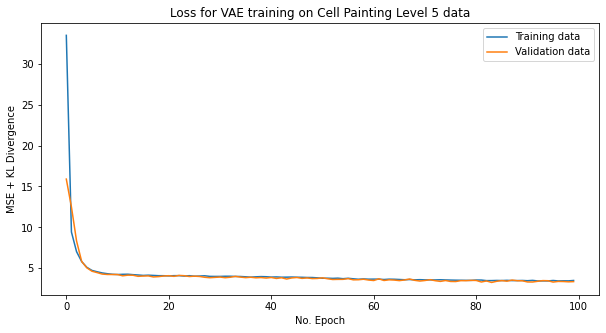

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [18]:
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
(sum(sum((np.array(test_features_df) - np.array(reconstruction)) ** 2))) ** 0.5

49.493420518887504

<AxesSubplot:>

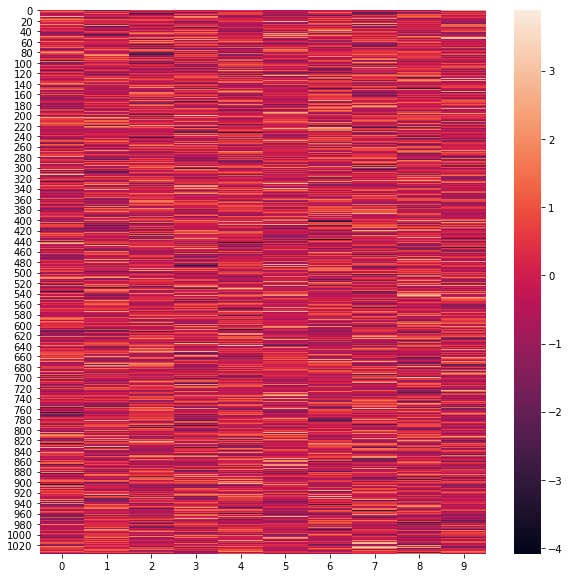

In [19]:
#latent space heatmap
fig, ax = plt.subplots(figsize=(10, 10))
encoder = cp_vae.encoder_block["encoder"]
latent = np.array(encoder.predict(test_features_df)[2])
seaborn.heatmap(latent, ax=ax)

In [20]:
#original vs reconstructed heatmap
reconstruction = pd.DataFrame(cp_vae.vae.predict(test_features_df), columns=cp_features)
pca = PCA(n_components=2).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))


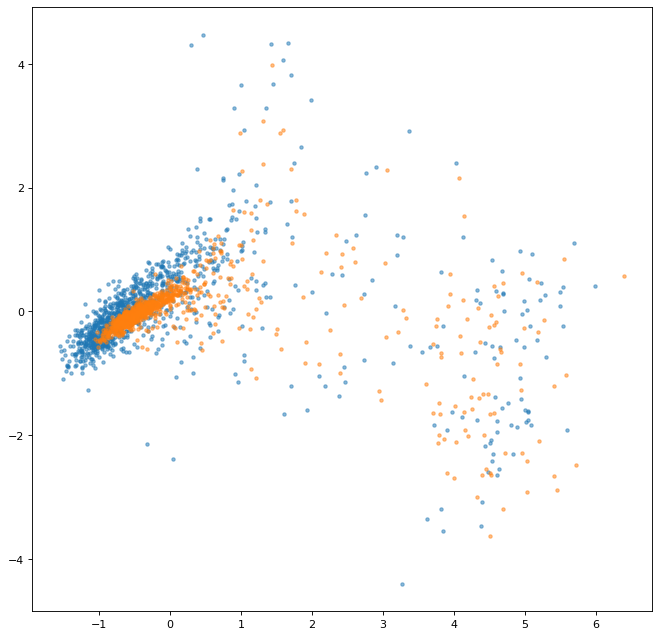

In [21]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[0],pca_test_latent_df[1], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[0],pca_reconstructed_latent_df[1], marker = ".", alpha = 0.5)

In [22]:
pca = PCA(n_components=50).fit(test_features_df)
pca_reconstructed_latent_df = pd.DataFrame(pca.transform(reconstruction))
pca_test_latent_df = pd.DataFrame(pca.transform(test_features_df))

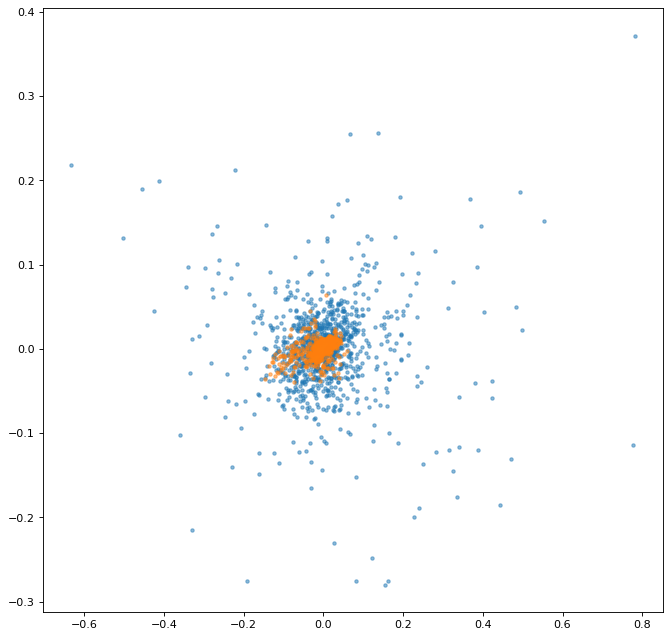

In [23]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(pca_test_latent_df[21],pca_test_latent_df[43], marker = ".", alpha = 0.5)
plt.scatter(pca_reconstructed_latent_df[21],pca_reconstructed_latent_df[43], marker = ".", alpha = 0.5)

<AxesSubplot:>

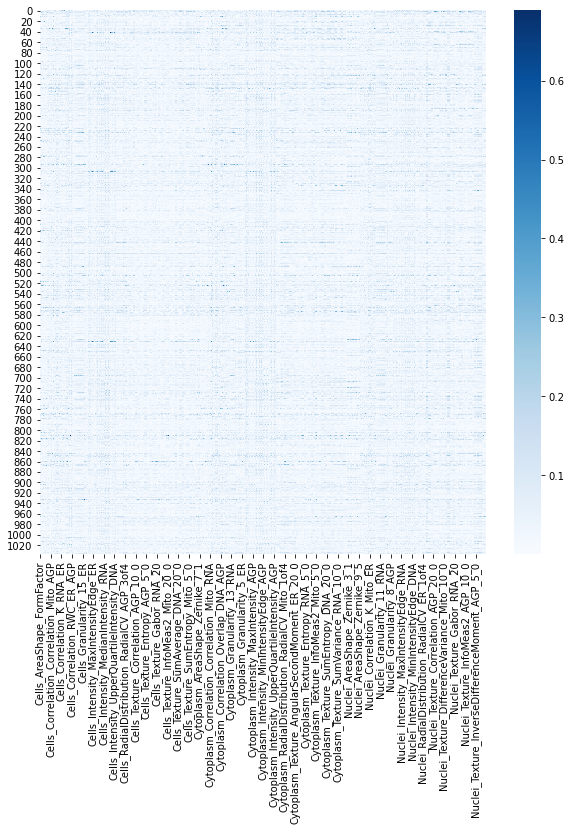

In [130]:
#difference between original and reconstructed heatmap
difference = abs(reconstruction - test_features_df)
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(difference, ax=ax, cmap="Blues")

<AxesSubplot:>

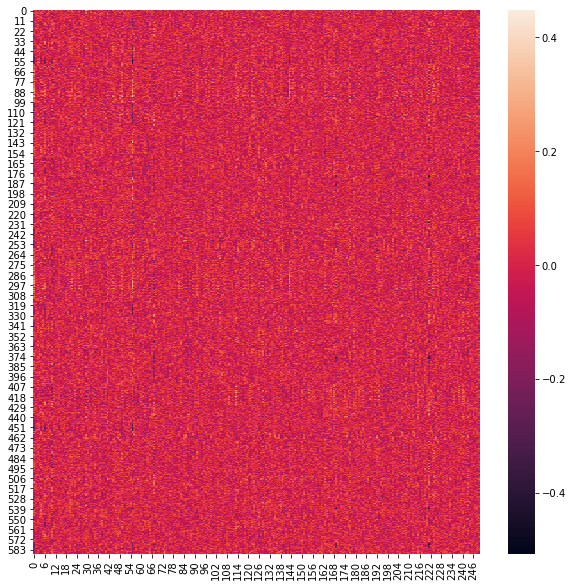

In [131]:
#encoder heatmap
weights = cp_vae.encoder_block["encoder"].get_weights()
fig, ax = plt.subplots(figsize=(10, 10))
seaborn.heatmap(weights[0], ax=ax)

In [26]:
decoder = cp_vae.decoder_block["decoder"]

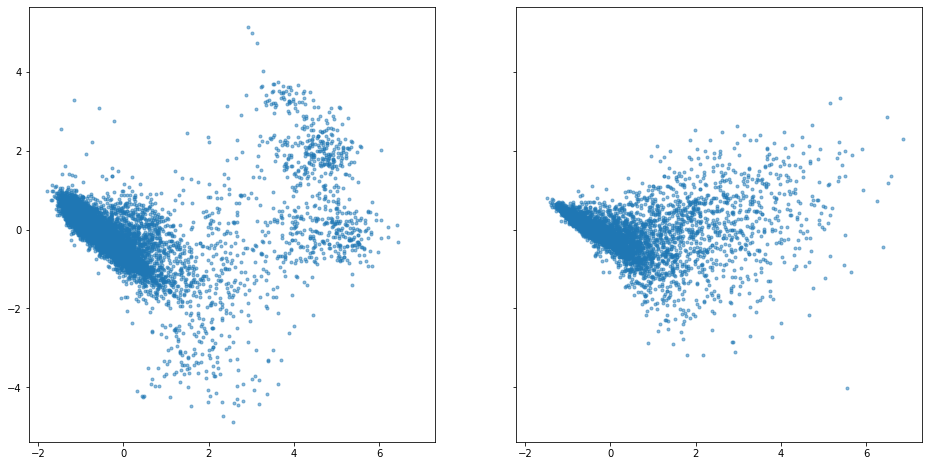

In [27]:

pca_training = PCA(n_components=2).fit(train_features_df)

simulated_df = pd.DataFrame(np.random.normal(size=(8294, 10)), columns=np.arange(0,10))
reconstruction_of_simulated = decoder.predict(simulated_df)
pca_reconstruction_of_simulated = pd.DataFrame(pca_training.transform(reconstruction_of_simulated))
pca_train_latent_df = pd.DataFrame(pca_training.transform(train_features_df))

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16,8), sharey = True, sharex = True)
ax1.scatter(pca_train_latent_df[0],pca_train_latent_df[1], marker = ".", alpha = 0.5)
ax2.scatter(pca_reconstruction_of_simulated[0],pca_reconstruction_of_simulated[1], marker = ".", alpha = 0.5)

In [28]:
from scipy.spatial.distance import directed_hausdorff
max(directed_hausdorff(reconstruction_of_simulated, train_features_df)[0],directed_hausdorff(train_features_df,reconstruction_of_simulated)[0])

6.1153968569401265

In [33]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
latent_complete = np.array(encoder.predict(complete_features_df)[2])
latent_df = pd.DataFrame(latent_complete)
latent_df.to_csv("../3.application/level5Latent_vanilla.csv")

In [3]:
reducer = umap.UMAP()
latent_embedding = reducer.fit_transform(latent_df)

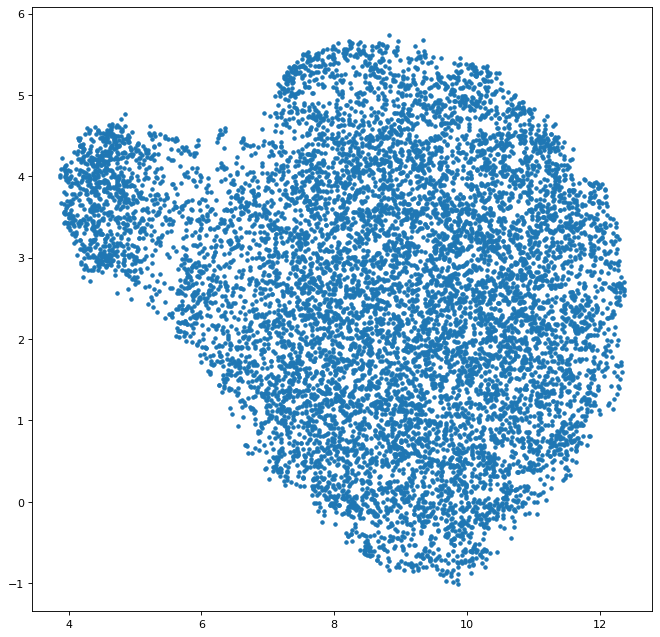

In [4]:
figure(figsize=(10, 10), dpi=80)
plt.scatter(
    latent_embedding[:, 0],
    latent_embedding[:, 1],
    marker = '.'
)

In [34]:
#NOTE: IF YOU RUN THIS, YOU WILL NOT BE ABLE TO REPRODUCE THE EXACT RESULTS IN THE EXPERIMENT
decoder.save("models/level5Decoder_vanilla")

INFO:tensorflow:Assets written to: level5Decoder_vanilla/assets


In [35]:
encoder.save("models/level5Encoder_vanilla")

INFO:tensorflow:Assets written to: level5Encoder_vanilla/assets
